In [1]:
!pip install scikit-learn-intelex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 74.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 45.5 MB/s eta 0:00:00


In [2]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sys
import os
import io

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from contextlib import redirect_stdout


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df1 = pd.read_csv('/content/drive/MyDrive/processed_kaggle.csv')
df2 = pd.read_csv('/content/drive/MyDrive/processed_reddit_mbti.csv')
train_reddit = df2.sample(frac=0.8, random_state=42)
test_reddit = df2.drop(train_reddit.index)

df = pd.concat([df1, train_reddit])

p_types = ['E/I', 'S/N', 'T/F', 'J/P']


In [7]:
print(df)

      type                                              posts
0     INFJ  moment http sportscent top ten play http exper...
1     ENTP  find lack post bore posit often exampl girlfri...
2     INTP  one http cours say know bless absolut posit be...
3     INTJ  enjoy convers day esoter gab natur univers ide...
4     ENTJ  anoth silli misconcept approach logic go key u...
...    ...                                                ...
1387  enfp  im die hard anim advoc appreci awar problem se...
7243  infp  oh look forward quizz end make futur kept long...
6984  infp  opinion popul state big citi plu new england n...
6209  intp  add jungian think psychodynam profil help imme...
6648  intp  nice home mayb start welcom life may help expe...

[14849 rows x 2 columns]


In [8]:
def preprocess(df, p_type, get_vectorizer=False):
  df_new = df.copy()
  if p_type == 'E/I':
    df_new[p_type] = df['type'].apply(lambda x: x[0].lower() == 'e').astype(int)
  elif p_type == 'S/N':
    df_new[p_type] = df['type'].apply(lambda x: x[1].lower() == 's').astype(int)
  elif p_type == 'T/F':
    df_new[p_type] = df['type'].apply(lambda x: x[2].lower() == 't').astype(int)
  elif p_type == 'J/P':
    df_new[p_type] = df['type'].apply(lambda x: x[3].lower() == 'j').astype(int)

  # # balancing dataset - downsample to match the class with fewer observations
  min_count = df_new[p_type].value_counts().min()
  max_count = df_new[p_type].value_counts().max()

  df_balanced = pd.concat([df_new[df_new[p_type] == i].sample(min_count, random_state=42) for i in df_new[p_type].unique()])

  # convert tokens to vectors (tf-idf)
  vectorizer = TfidfVectorizer()
  X = vectorizer.fit_transform(df_balanced['posts'])
  y = df_balanced[p_type]

  if get_vectorizer: return X, y, df_balanced, vectorizer

  return X, y, df_balanced

In [9]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))


In [10]:
def plotCM(y_test, y_pred, p_type):
    # Input - the model, X_test and y_test 
    # output - None - simply plot the confusion matrix

    # Generate confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    
    # Normalize confusion matrix
    normalized_cf_matrix = cf_matrix.astype(float)/np.array([np.sum(cf_matrix.astype(float), axis=1)]).T

    # Plot the confusion matrix
    plt.figure(figsize=(10,10))
    sns.heatmap(normalized_cf_matrix, 
                annot=True, 
                linewidths=.5, 
                square = True, 
                cmap = 'Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = p_type
    plt.title(all_sample_title, size=10)


In [11]:
params = {}
for p_type in p_types :
  params[p_type] = {}


params['E/I'] = {
    'n_estimators': 200,
		'max_depth': 2,
		'learning_rate': 0.1,
		'min_child_weight': 5,
		'gamma': 0.5,
		'alpha': 0,
		'lambda': 0.5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
}

params['S/N'] = {
    'n_estimators': 200,
		'max_depth': 10,
		'learning_rate': 0.1,
		'min_child_weight': 5,
		'gamma': 0.5,
		'alpha': 0,
		'lambda': 0.5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
}

params['T/F'] = {
    'n_estimators': 200,
		'max_depth': 10,
		'learning_rate': 0.1,
		'min_child_weight': 5,
		'gamma': 0.5,
		'alpha': 0,
		'lambda': 0.5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
}

params['J/P'] = {
    'n_estimators': 200,
		'max_depth': 10,
		'learning_rate': 0.1,
		'min_child_weight': 5,
		'gamma': 0.5,
		'alpha': 0,
		'lambda': 0.5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
}


for p_type in p_types :
  params[p_type].update(
      {
        'tree_method' : 'gpu_hist', 
        'random_state' : 42,
        'num_boost_round' : 1000,
        'verbosity' : 0,
        'eval_metric' : 'logloss'
      }
  )



In [23]:
class XGBoostTextClassifier:
  def __init__(self) -> None:
    self.tokenizers = {}
    self.models = {}
    self.p_types = p_types
    for p_type in p_types:
      self.tokenizers[p_type] = None
      self.models[p_type] = None
  
  def train(self, df, train_size=0.6, eval_size=0.2, time=True, graph=True) -> None:
    for p_type in self.p_types:
      start_time = None
      if time: start_time = timer(None)


      X, y, df_balanced, self.tokenizers[p_type] = preprocess(df, p_type, get_vectorizer=True)
      X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                      train_size=train_size+eval_size,
                                                      random_state=42)
      X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                        train_size = train_size/(train_size+eval_size),
                                                        random_state=42)

      model = xgb.XGBClassifier(**params[p_type]);

      eval_set = [(X_train, y_train), (X_val, y_val)]


      out = io.StringIO()
      with redirect_stdout(out):
        model.fit(X_train, y_train, eval_set=eval_set);

      self.models[p_type] = model

      eval_metric = model.get_params()['eval_metric']

      results = model.evals_result()
      epochs = len(results['validation_0'][eval_metric])
      x_axis = range(0, epochs)

      y_train_pred = model.predict(X_train)

      train_accuracy = (accuracy_score(y_train, y_train_pred)) * 100

      y_pred = model.predict(X_test)

      accuracy = (accuracy_score(y_test, y_pred)) * 100
      print(p_type)
      print(f'Training Accuracy of {p_type}: {train_accuracy}')
      print(f'Testing Accuracy of {p_type}: {accuracy}')

      if graph: 
        plotCM(y_test, y_pred, p_type)
        fig, ax = plt.subplots(figsize=(10,8))
        ax.plot(x_axis, results['validation_0'][eval_metric], label='Train')
        ax.plot(x_axis, results['validation_1'][eval_metric], label='Validation')
        ax.legend()
        plt.ylabel(eval_metric)
        plt.title('XGBoost ' + eval_metric)
        plt.show()

      if time: start_time = timer(start_time)

  def predict_sample(self, input):
    # Input can be either a single sample or a df
    labels = {}
    for p_type in self.p_types:
      predicted_type = None
      vectorized_input = self.tokenizers[p_type].transform([input])
      # print(textClassifier.models[p_type])
      raw_labels = self.models[p_type].predict(vectorized_input)

      if len(p_type) >= 3:
        axis = np.array([p_type[2], p_type[0]])
      else:
        print('wiener')
        
      labels[p_type] = axis[raw_labels]
      labels[p_type] = self.models[p_type].predict(vectorized_input)
    print(labels)

  def predict_df(self, input):
    # Input can be either a single sample or a df
    labels = {}
    for p_type in self.p_types:
      predicted_type = None
      vectorized_input = self.tokenizers[p_type].transform(input)
      # print(textClassifier.models[p_type])
      raw_labels = self.models[p_type].predict(vectorized_input)

      if len(p_type) >= 3:
        axis = np.array([p_type[2], p_type[0]])
      else:
        print('wiener')
        
      labels[p_type] = axis[raw_labels]
      labels[p_type] = self.models[p_type].predict(vectorized_input)
    print(labels)

  def accuracy_score(self, test_df) :
      accuracies = {}
      input = test_df['posts']
      for p_type in self.p_types:
        X = self.tokenizers[p_type].transform(input)
        y = None
        if p_type == 'E/I':
          y = test_df['type'].apply(lambda x: x[0].lower() == 'e').astype(int)
        elif p_type == 'S/N':
          y = test_df['type'].apply(lambda x: x[1].lower() == 's').astype(int)
        elif p_type == 'T/F':
          y = test_df['type'].apply(lambda x: x[2].lower() == 't').astype(int)
        elif p_type == 'J/P':
          y = test_df['type'].apply(lambda x: x[3].lower() == 'j').astype(int)
        y_pred = self.models[p_type].predict(X)
        accuracies[p_types] = accuracy_score(y, y_pred)
      print(accuracies)
    

  def save(self):
    with open('/content/drive/MyDrive/XGBoostTextClassifier', 'wb') as f:
      pickle.dump(self, f)

  @classmethod
  def load():
    with open('/content/drive/MyDrive/XGBoostTextClassifier', 'rb') as f:
      return pickle.load(f)


In [13]:
params = {}
for p_type in p_types :
  params[p_type] = {}


params['E/I'] = {
    'n_estimators': 200,
		'max_depth': 2,
		'learning_rate': 0.1,
		'min_child_weight': 5,
		'gamma': 0.5,
		'alpha': 0,
		'lambda': 0.5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
}

params['S/N'] = {
    'n_estimators': 200,
		'max_depth': 10,
		'learning_rate': 0.1,
		'min_child_weight': 5,
		'gamma': 0.5,
		'alpha': 0,
		'lambda': 0.5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
}

params['T/F'] = {
    'n_estimators': 200,
		'max_depth': 10,
		'learning_rate': 0.1,
		'min_child_weight': 5,
		'gamma': 0.5,
		'alpha': 0,
		'lambda': 0.5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
}

params['J/P'] = {
    'n_estimators': 200,
		'max_depth': 10,
		'learning_rate': 0.1,
		'min_child_weight': 5,
		'gamma': 0.5,
		'alpha': 0,
		'lambda': 0.5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
}



In [14]:
params = {}

params['E/I'] = {
    # 'tree_method':'gpu_hist',
    'n_estimators': 400,
		'max_depth': 3,
		'learning_rate': 0.15,
		'min_child_weight': 5,
		'gamma': 2,
		'alpha': 10,
		'lambda': 10,
    'subsample': 0.5,
    'colsample_bytree': 0.5,
    'eval_metric' : 'auc',
}

params['S/N'] = {
    'n_estimators': 400,
		'max_depth': 3,
		'learning_rate': 0.15,
		'min_child_weight': 10,
		'gamma': 5,
		'alpha': 10,
		'lambda': 10,
    'subsample': 0.5,
    'colsample_bytree': 0.5,
    'eval_metric' : 'auc',
}

params['T/F'] = {
    'n_estimators': 400,
		'max_depth': 3,
		'learning_rate': 0.3,
		'min_child_weight': 3,
		'gamma': 5,
		'alpha': 12,
		'lambda': 14,
    'subsample': 0.5,
    'colsample_bytree': 0.5,
    'eval_metric' : 'auc',
}

params['J/P'] = {
    'n_estimators': 400,
		'max_depth': 2,
		'learning_rate': 0.1,
		'min_child_weight': 10,
		# 'gamma': 3,
		'alpha': 15,
		'lambda': 15,
    'subsample': 0.5,
    'colsample_bytree': 0.5,
    'eval_metric' : 'logloss',
}

for p_type in p_types :
  params[p_type].update(
      {
        'random_state' : 42,
      }
  )

E/I
Training Accuracy of E/I: 87.11145996860282
Testing Accuracy of E/I: 61.10414052697616


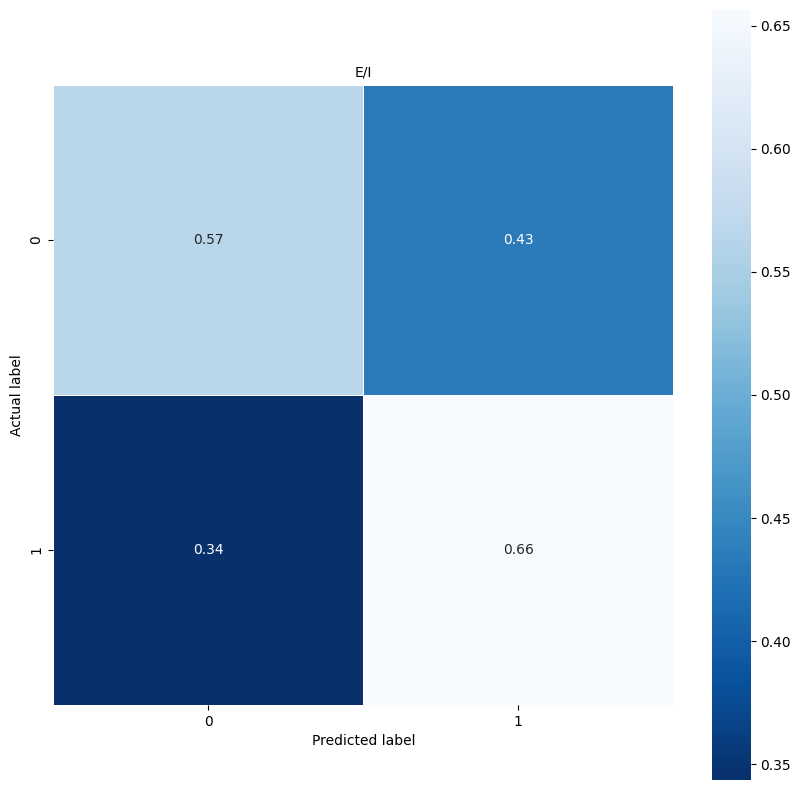

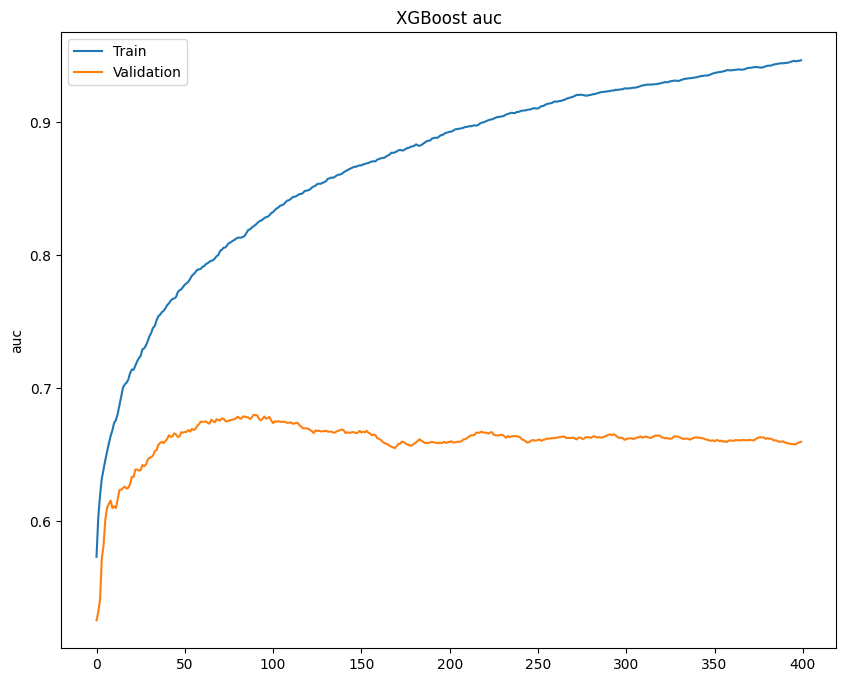


 Time taken: 0 hours 0 minutes and 31.76 seconds.
S/N
Training Accuracy of S/N: 80.32511210762333
Testing Accuracy of S/N: 60.62639821029083


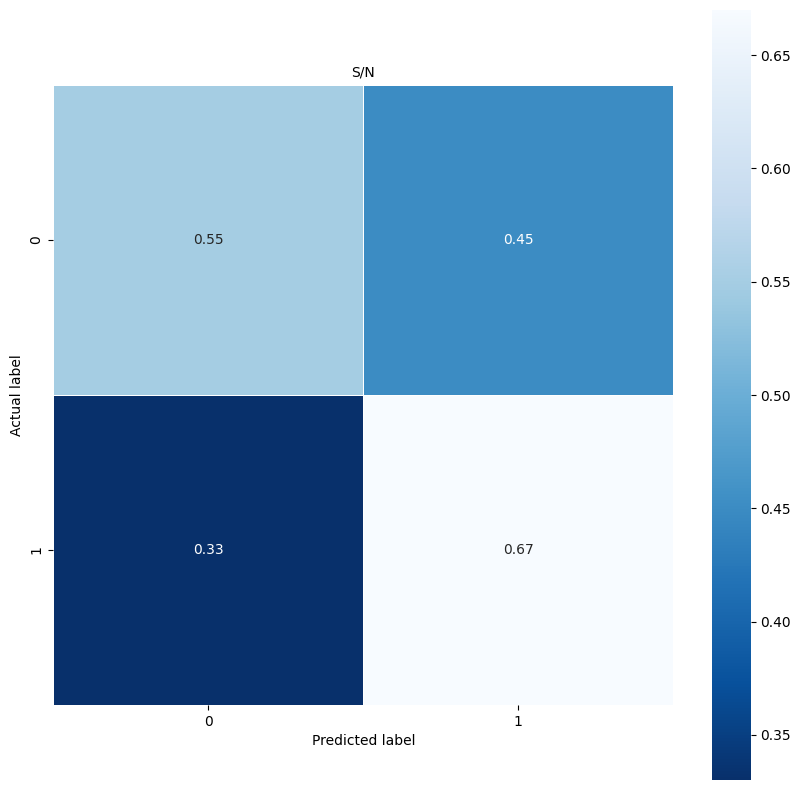

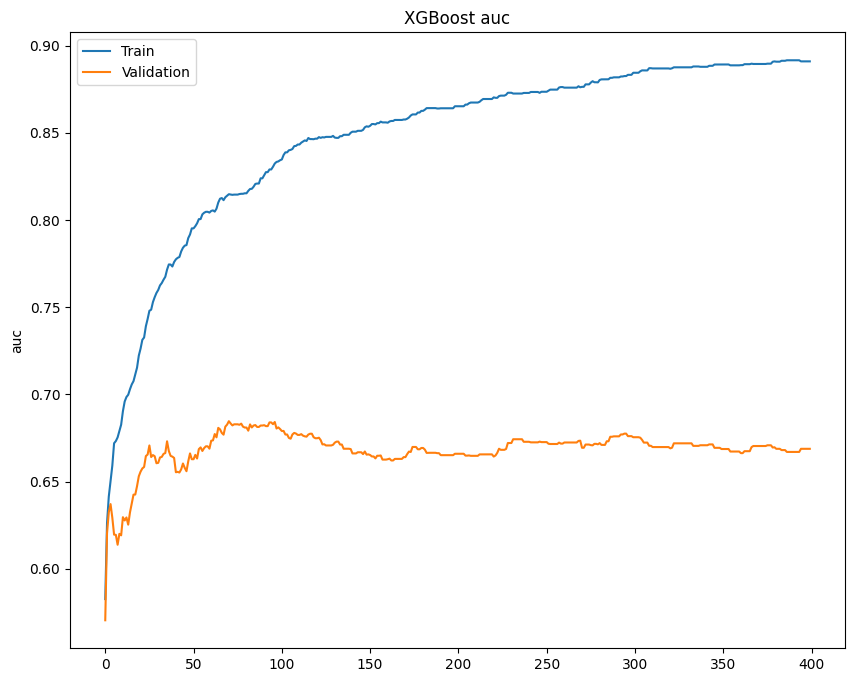


 Time taken: 0 hours 0 minutes and 17.28 seconds.
T/F
Training Accuracy of T/F: 83.18943626206196
Testing Accuracy of T/F: 69.87136086662153


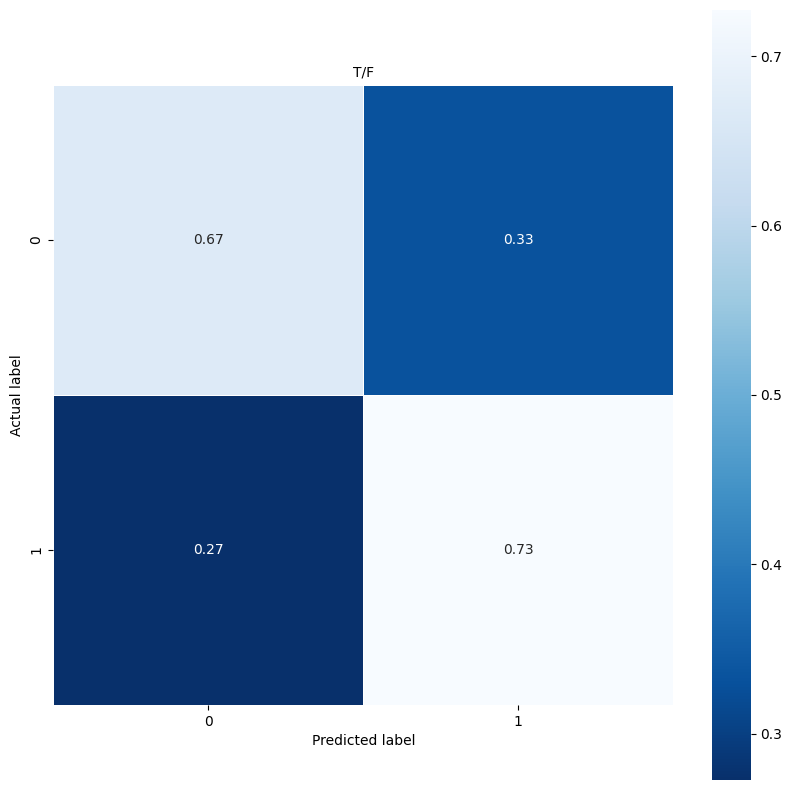

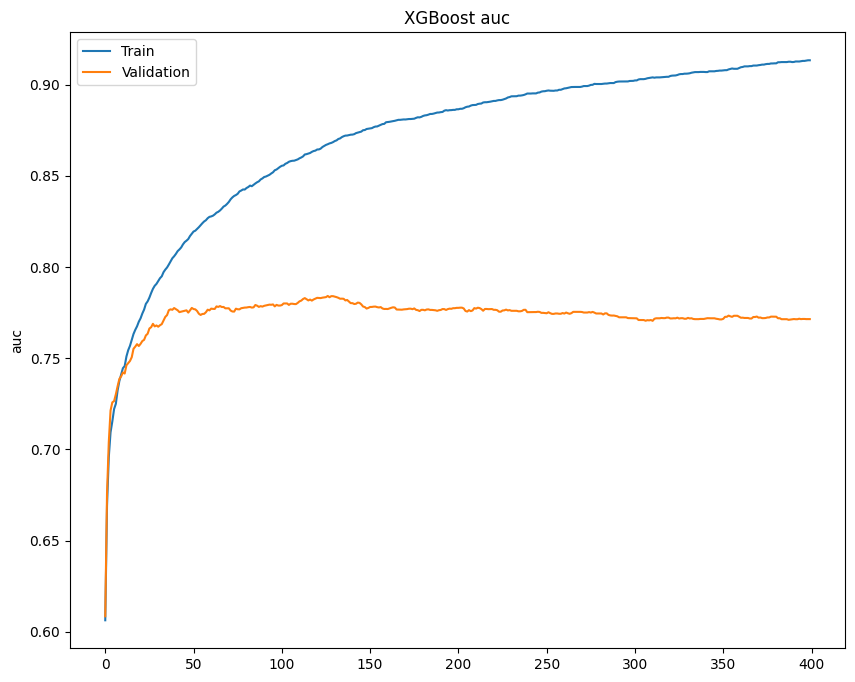


 Time taken: 0 hours 0 minutes and 50.24 seconds.
J/P
Training Accuracy of J/P: 71.85827445943053
Testing Accuracy of J/P: 57.705479452054796


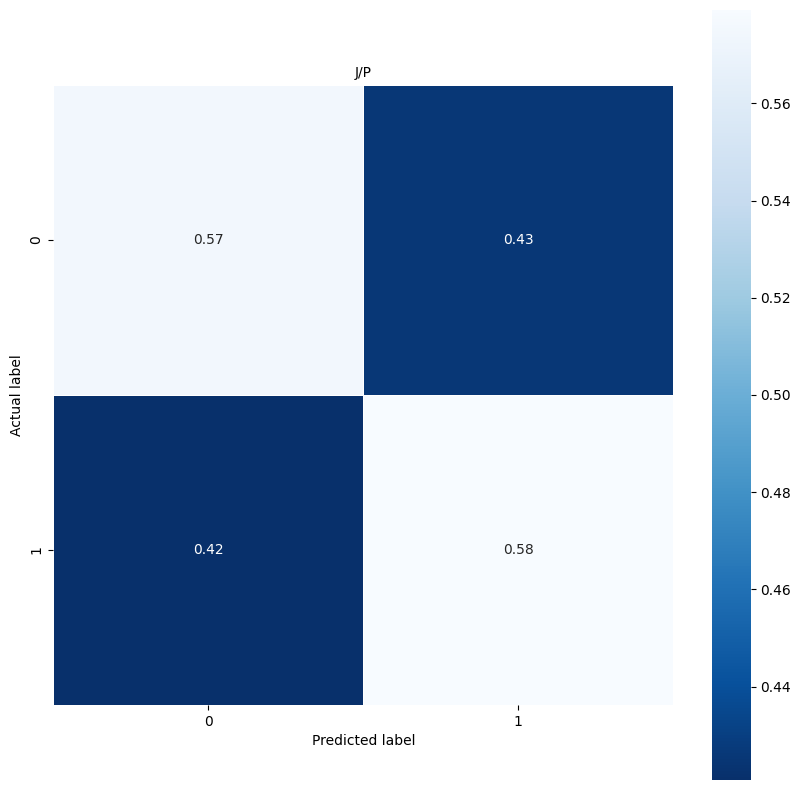

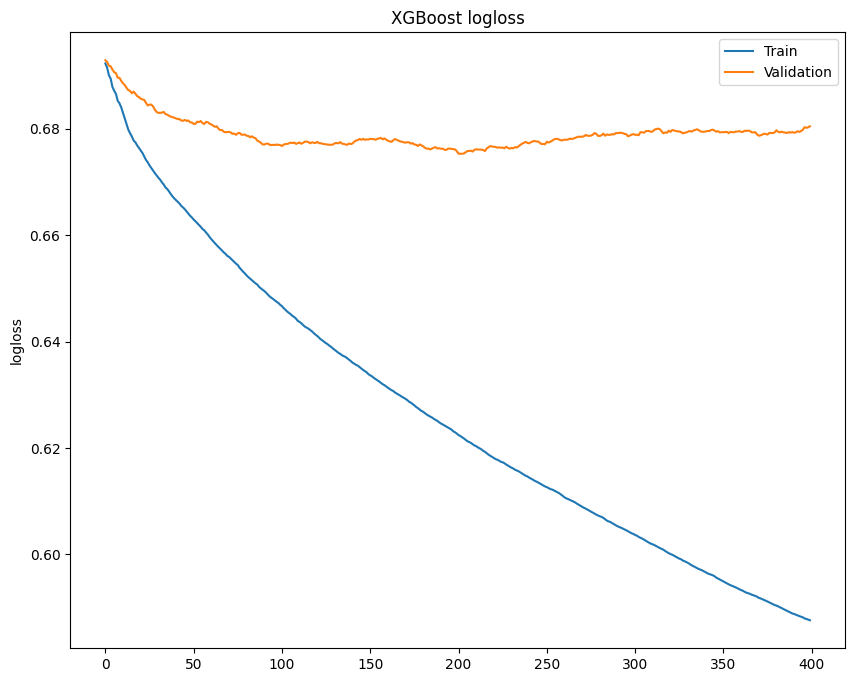


 Time taken: 0 hours 0 minutes and 33.41 seconds.


In [24]:
textClassifier = XGBoostTextClassifier()
textClassifier.train(df, 0.8, 0.1, True, True)
textClassifier.save()

In [46]:
input = """
"I need some alone time to recharge my batteries."
"I prefer to listen rather than talk."
"I feel more comfortable in small groups or one-on-one conversations."
"I need some time to think before I make a decision."
"I like to observe and take in my surroundings before I jump into a conversation."
"I'm not great at small talk, but I'm happy to talk about deeper topics."
"I don't like being the center of attention."
"I enjoy spending time by myself, reading, or doing something creative."
"I tend to get overwhelmed in loud or crowded environments."
"I feel like I need to get to know someone before I feel comfortable opening up."
"""
labels = {}
for p_type in textClassifier.p_types:
  predicted_type = None
  vectorized_input = textClassifier.tokenizers[p_type].transform([input])
  # print(textClassifier.models[p_type])
  raw_labels = textClassifier.models[p_type].predict(vectorized_input)

  if len(p_type) >= 3:
    axis = np.array([p_type[2], p_type[0]])
  else:
    print('wiener')
    
  labels[p_type] = axis[raw_labels]
  labels[p_type] = textClassifier.models[p_type].predict(vectorized_input)
print(labels)

{'E/I': array([0]), 'S/N': array([1]), 'T/F': array([1]), 'J/P': array([1])}


In [18]:
textClassifier.predict_sample(input)

{'E/I': array([0]), 'S/N': array([1]), 'T/F': array([1]), 'J/P': array([1])}


In [17]:
textClassifier.accuracy_score(test_reddit)

ValueError: ignored

In [45]:
accuracies = {}
input = test_reddit['posts']
for p_type in textClassifier.p_types:
  
  X = textClassifier.tokenizers[p_type].transform(input)
  y = None
  if p_type == 'E/I':
    y = test_reddit['type'].apply(lambda x: x[0].lower() == 'e').astype(int)
  elif p_type == 'S/N':
    y = test_reddit['type'].apply(lambda x: x[1].lower() == 's').astype(int)
  elif p_type == 'T/F':
    y = test_reddit['type'].apply(lambda x: x[2].lower() == 't').astype(int)
  elif p_type == 'J/P':
    y = test_reddit['type'].apply(lambda x: x[3].lower() == 'j').astype(int)
  y_pred = textClassifier.models[p_type].predict(X)
  accuracies[p_type] = accuracy_score(y, y_pred)
print(accuracies)

{'E/I': 0.5058290155440415, 'S/N': 0.4494818652849741, 'T/F': 0.6275906735751295, 'J/P': 0.5718911917098446}


In [43]:
X = textClassifier.tokenizers[p_type].transform(input)

In [44]:
y_pred = textClassifier.models[p_type].predict(X)

In [34]:
p_types

['E/I', 'S/N', 'T/F', 'J/P']

SPACER

In [ ]:
for p_type in p_types[0:4]:
    params = { 
                'tree_method':'gpu_hist'
              }
    train_size = 0.6
    eval_size = 0.2

    X, y, df_balanced = preprocess(df, p_type)

    print(p_type)
    print('Negative count:' + str(np.sum(y==0)))
    print('Positive count:' + str(np.sum(y==1)))

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        train_size=train_size+eval_size,
                                                        random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                      train_size=train_size/(train_size+eval_size),
                                                      random_state=42)


    # model = xgb.XGBClassifier(max_depth=2, tree_method='gpu_hist', random_state=42, scale_pos_weight=scale_pos_weight, verbose=0)
    # print(model)
    # model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)

    # # scores = cross_val_score(model, X_train, y_train, cv=5)
    # # print("Mean cross-validation score: %.2f" % scores.mean())

    # # kfold = StratifiedKFold(n_splits=10, shuffle=True)
    # # kf_cv_scores = cross_val_score(model, X_train, y_train, cv=kfold )
    # # print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

    # y_train_pred = model.predict(X_train)

    # train_accuracy = (accuracy_score(y_train, y_train_pred)) * 100
    # print(f'Training Accuracy of {p_type}: {train_accuracy}')

    # y_pred = model.predict(X_test)
    # print(model.get_params()['tree_method'])
    # plotCM(y_test, y_pred, p_type)

    # accuracy = (accuracy_score(y_test, y_pred)) * 100
    # print(f'Testing Accuracy of {p_type}: {accuracy}')


E/I
Negative count:2451
Positive count:2451
S/N
Negative count:1290
Positive count:1290
T/F
Negative count:3345
Positive count:3345
J/P
Negative count:3024
Positive count:3024


In [ ]:
print(np.sum(y_train==0), np.sum(y_train==1))

1813 1815


In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Generate some example data
X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, weights=[0.9, 0.1], random_state=42)

# Compute class weights based on label frequencies
class_weights = len(y) / (2 * np.bincount(y))

In [ ]:
# k-fold Cross Validation
for p_type in p_types:

    param = {'max_depth':2, 'eta':1, 'objective':'binary:logistic'}
    num_round = 2
    train_size = 0.8



    X, y, df_balanced = preprocess(df, p_type)
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=train_size,
                                                    random_state=42)
    
    train_d_matrix = xgb.DMatrix(data=X_train,label=y_train)

    start_time = timer(None)

    print(xgb.cv(param, train_d_matrix, num_round, nfold=5,
           metrics={'error'}, seed=42))
    
    timer(start_time)
    
    
    # y_train_pred = model.predict(X_train)

    # train_accuracy = (accuracy_score(y_train, y_train_pred)) * 100
    # print(f'Training Accuracy of {p_type}: {train_accuracy}')

    # y_pred = model.predict(X_test)
    # plotCM(y_test, y_pred, p_type)

    # accuracy = (accuracy_score(y_test, y_pred)) * 100
    # print(f'Testing Accuracy of {p_type}: {accuracy}')


   train-error-mean  train-error-std  test-error-mean  test-error-std
0          0.411273         0.008410         0.427457        0.014796
1          0.391650         0.008039         0.433703        0.025173

 Time taken: 0 hours 0 minutes and 2.72 seconds.
   train-error-mean  train-error-std  test-error-mean  test-error-std
0          0.391384         0.012848         0.449086        0.017709
1          0.369060         0.012320         0.444386        0.010099

 Time taken: 0 hours 0 minutes and 1.02 seconds.
   train-error-mean  train-error-std  test-error-mean  test-error-std
0          0.350918         0.012385         0.358928        0.007807
1          0.330507         0.006322         0.352175        0.007778

 Time taken: 0 hours 0 minutes and 3.01 seconds.
   train-error-mean  train-error-std  test-error-mean  test-error-std
0          0.441436         0.007227         0.454680        0.023001
1          0.412405         0.007404         0.437204        0.020175

 Time tak

In [ ]:
# train_size = 0.8
# validation_size = 0.1
# test_size = 0.1


hyperparameter_grid = {
    'n_estimators': [100, 200, 400],
    'max_depth': [2, 5, 10],
    'learning_rate': [0.05, 0.1, 0.20],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.01, 0.05, 0.1, 0.5, 1],
    'alpha': [0, 0.1, 0.5],
    'lambda': [0, 0.1, 0.5],
    'early_stopping_rounds': [10]
    }

models = {}

accuracies = []

for p_type in p_types:
  X, y, df_balanced = preprocess(df, p_type)

  train_size = 0.6
  eval_size = 0.2

  X, y, df_balanced = preprocess(df, p_type)
  X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                  train_size=train_size+eval_size,
                                                  random_state=42)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    train_size = train_size/(train_size+eval_size),
                                                    random_state=42)
  model = xgb.XGBClassifier(learning_rate=0.02, 
                            n_estimators=60, 
                            objective='binary:logistic',
                            verbose=0, 
                            random_state=42)
  
  folds = 3
  skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42)


  param_comb = 100
  random_search = RandomizedSearchCV(model, 
                                     param_distributions=hyperparameter_grid, 
                                     n_iter=param_comb, 
                                     n_jobs=-1, 
                                     cv=skf.split(X_train,y_train),
                                     verbose=1, 
                                     random_state=42,
                                     refit=True,
                                     error_score='raise')
  
  fit_params = {
    "eval_metric": "logloss",
    "eval_set": [(X_val, y_val)]
  }

  start_time = timer(None)
  random_search.fit(X_train,y_train, **fit_params)
  timer(start_time)

  print(random_search.best_estimator_)
  best_model = random_search.best_estimator_
  models[p_type] = best_model

  y_train_pred = best_model.predict(X_train)

  print('Best hyperparameters for ' + p_type + ':')
  for hyperparameter, value in hyperparameter_grid.items():
    print("'" + hyperparameter + "':  "+ str(best_model.get_params()[hyperparameter]))
  train_accuracy = (accuracy_score(y_train, y_train_pred)) * 100
  print(f'Training Accuracy of {p_type}: {train_accuracy}')

  y_pred = best_model.predict(X_test)
  accuracy = (accuracy_score(y_test, y_pred)) * 100
  accuracies.append(accuracy)

  with open('/content/drive/MyDrive/best_mode_' + p_type[0] + '_' + p_type[2] +'_l.pkl', 'wb') as f:
    pickle.dump(best_model, f)


  print(f'Accuracy of {p_type}: {accuracy}')

  plotCM(y_test, y_pred, p_type)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: ignored

In [ ]:
with open('test.txt', 'w') as f:
  f.write('Test')

In [ ]:
with open('/content/drive/MyDrive/best_mode_' + p_type[0] + '_' + p_type[2] +'_l.pkl', 'wb') as f:
    pickle.dump(best_model, f)
